In [110]:
import os
import yaml
import pickle
import imageio
from PIL import Image
from typing import Callable
import itertools
import string
import re

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from src.models import NCA, PINCA

# Loading the Model

In [135]:
config_path = f'./conf/config_nca_leopard_100x100.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

# these parameters can change during postprocessing evaluation
device = torch.device('cpu')
fire_rate = 0.5 # fire rate directly governs the speed of the process development
value_range = (0.0, 1.0)
padding_mode = "circular"
    
if config['model']['type'] == 'NCA':
    model = NCA(hidden_size=config['nca_specific']['hidden_layer_size'], 
                n_channels=config['automaton_settings']['channels']['number'], 
                fire_rate=fire_rate, 
                init_weight_factor=config['automaton_settings']['neural_net']['initial_weight_factor'],
                value_range=value_range, 
                filter_size=config['filters']['size'],
                n_filters=config['filters']['number'],
                learnable_filters=config['filters']['learnable'], 
                padding_mode=padding_mode,
                filters_custom_init=config['filters']['custom_init'],
                device=device,
                filters_init_values=config['filters']['initial_values'],
                padding_values=config['automaton_settings']['channels']['padding']['values'])
elif config['model']['type'] == 'PINCA':
    model = PINCA(term_max_power=config['pinca_specific']['term_max_power'], 
                  n_channels=config['automaton_settings']['channels']['number'], 
                  fire_rate=fire_rate, 
                  init_weight_factor=config['automaton_settings']['neural_net']['initial_weight_factor'],
                  value_range=value_range, 
                  filter_size=config['filters']['size'],
                  n_filters=config['filters']['number'],
                  learnable_filters=config['filters']['learnable'], 
                  padding_mode=padding_mode,
                  filters_custom_init=config['filters']['custom_init'],
                  device=device,
                  filters_init_values=config['filters']['initial_values'],
                  padding_values=config['automaton_settings']['channels']['padding']['values'])
    
model.load_state_dict(torch.load(config['model_path']))
# model.load_state_dict(torch.load(os.path.join(config['output_folder'], 'best_model.pth')))
init_state = torch.tensor(np.load(os.path.join(config['output_folder'], 'init_state.npy'))).to(device).detach()
postprocessing_folder_path = os.path.join(config['output_folder'], 'postprocessing/')
with open(config['loss_path'], 'rb') as file:
    loss_history = pickle.load(file)
    
n_channels = config['automaton_settings']['channels']['number']
simulation_steps = config['training']['simulation_steps']
print(f'Simulation steps used during training {simulation_steps}')

Simulation steps used during training [[35, 45], [35, 45]]


# Supporting Functions

In [136]:
def perform_run(init_state: torch.Tensor, steps: int, 
                alterating_function: Callable[[torch.Tensor, int], torch.Tensor] = lambda x, y: x):
    x_outs = [torch.clone(init_state)]
    for i in range(steps):
        x_in = x_outs[-1]
        x_in_altered = alterating_function(x_in, i)
        x_out = model(x_in_altered)
        x_outs.append(x_out)
    x_outs_np = torch.stack(x_outs).detach().cpu().numpy()[:, 0, :, :, :]
    return x_outs_np


def plot_states(x_outs_np):
    for x in x_outs_np:
        plt.imshow(x[:, :, 0], cmap='gray', interpolation='bilinear')
        plt.axis('off')
        plt.show()

        
def save_animation(x_outs_np, path): 
    fig, ax = plt.subplots(figsize=(5, 5))

    def update(i):
        ax.clear()
        ax.imshow(x_outs_np[i, :, :, 0], cmap='gray', interpolation='bilinear')
        ax.axis('off')
        
        step_text = f'Step: {i}'
        ax.text(0.02, 0.95, step_text, transform=ax.transAxes, color='green', fontsize=12)

    ani = FuncAnimation(fig, update, frames=len(x_outs_np), interval=100)
    plt.tight_layout(pad=0)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ani.save(path, writer='imagemagick')
    plt.close(fig)
    
    
def save_images(x_outs_np, path):
    images = (x_outs_np[:, :, :, 0] * 255.0).astype(np.uint8)

    for i in range(images.shape[0]):
        slicex = images[i, :, :]
        img = Image.fromarray(slicex, 'L')  # 'L' mode for grayscale    
        rgba_img = np.stack((slicex,)*3 + (np.full(slicex.shape, 255, dtype=np.uint8),), axis=-1)

        img = Image.fromarray(rgba_img, 'RGBA')
        img.save(f'{path}/{i}.png')
        
def get_simulation_plot(x_outs_np, path = None, ncols = None, nrows = None):
    n_steps = len(x_outs_np) - 1
    if ncols == None:
        ncols = int(np.sqrt(n_steps + 1))  # Determine the number of columns
    if nrows == None:
        nrows = (n_steps + 1) // ncols + ((n_steps + 1) % ncols > 0)  # Determine the number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for i in range(len(x_outs_np)):
        img = x_outs_np[i, :, :, 0]
        axes[i].imshow(img, cmap='gray')  # You can change the color map if needed
        axes[i].axis('off')  # Turn off axis numbering

    # Hide any unused subplots
    for ax in axes[len(x_outs):]:
        ax.axis('off')
    plt.tight_layout()

    if path is not None:
        plot_path = os.path.join(path, 'simulation.png')
        plt.savefig(plot_path)

# State Generation

In [137]:
x_outs = perform_run(init_state=init_state, steps=99)

In [113]:
x_outs_subset = []
for i in range(len(x_outs) - 10):
    if i % 5 == 0:
        x_outs_subset.append(x_outs[i])
x_outs_subset = np.array(x_outs_subset)

In [114]:
x_outs_subset.shape

(18, 110, 110, 3)

In [126]:
x_outs[71:72, 5:-5, 5:-5, :]

(110, 110, 3)

In [139]:
save_images(x_outs[71:72, 5:-5, 5:-5, :], '.')

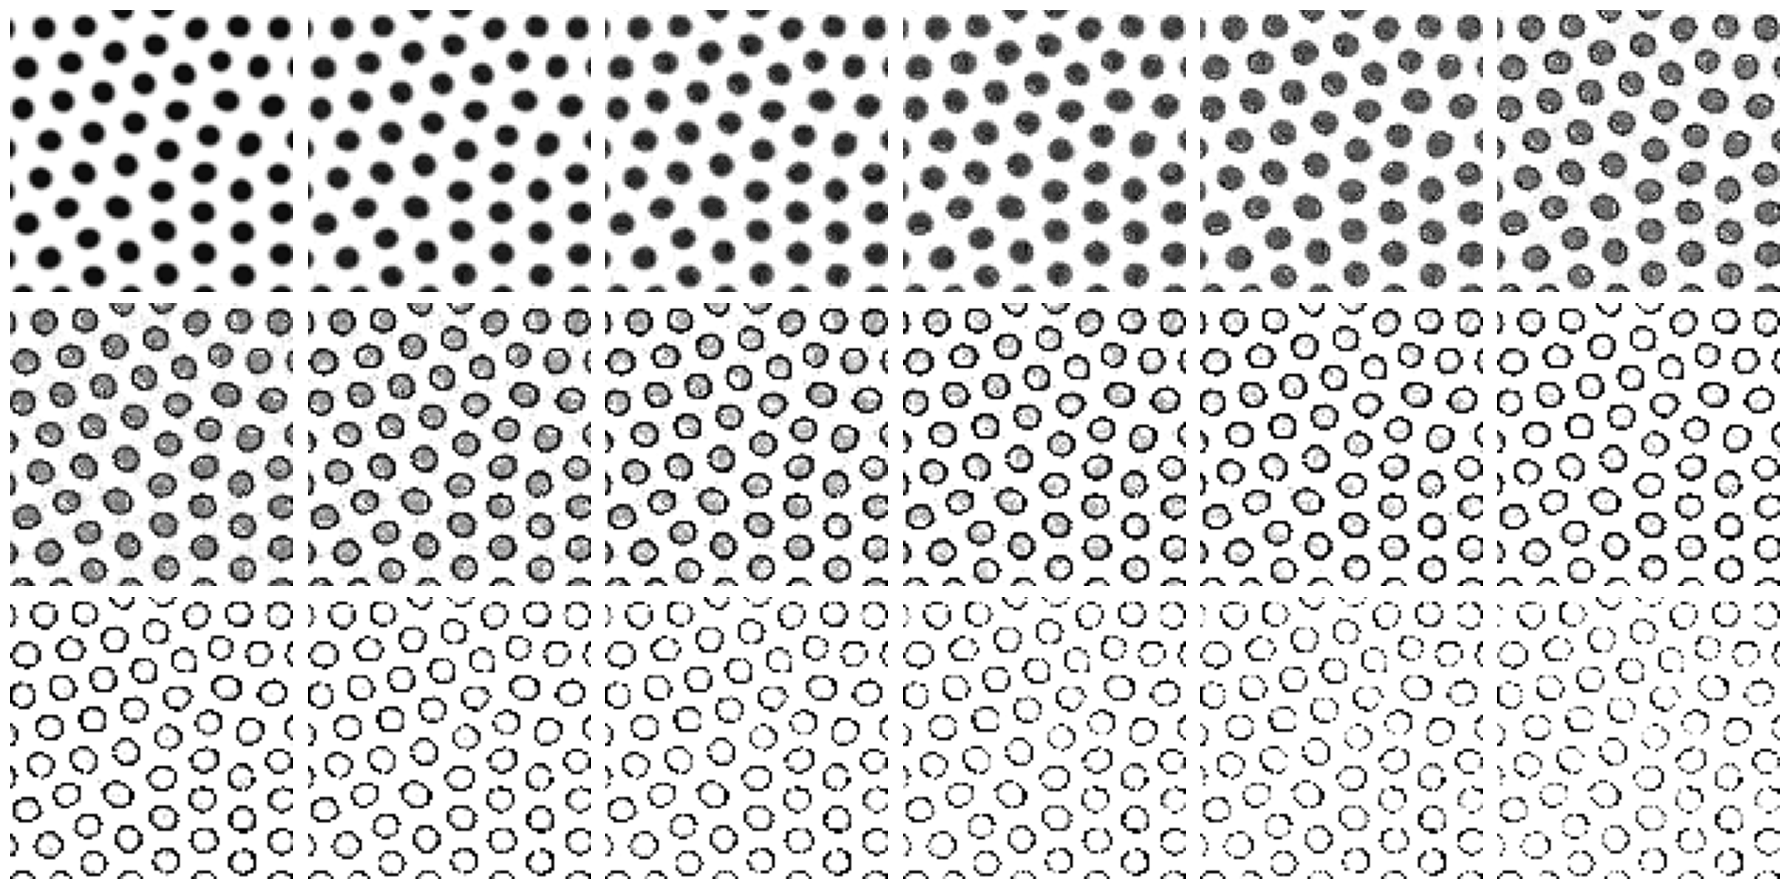

In [115]:
get_simulation_plot(x_outs_subset[:, 5:-5, 5:-5, :], '.', 6, 3)

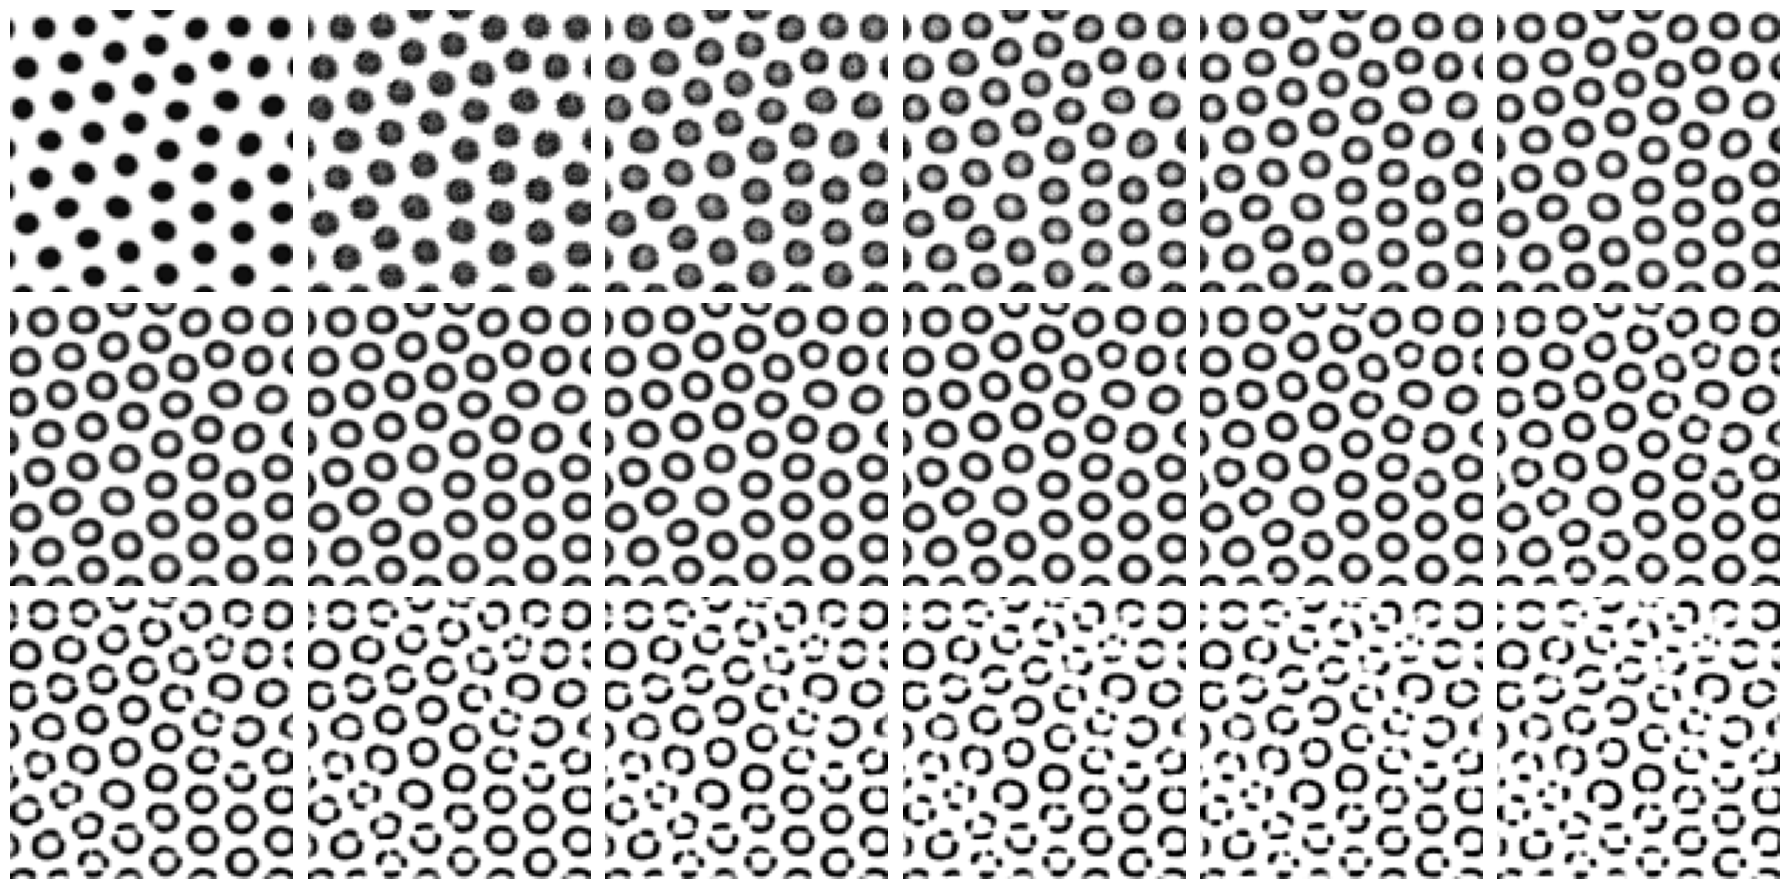

In [80]:
get_simulation_plot(x_outs_subset[:, 5:-5, 5:-5, :], '.', 6, 3)

In [14]:
save_animation(x_outs, os.path.join('.', 'animation_pinca_3c_fire_rate_0.gif'))

MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:
plot_states(x_outs)

In [ ]:
save_images(x_outs, os.path.join(postprocessing_folder_path, 'generated_states'))

In [ ]:
save_animation(x_outs, os.path.join(postprocessing_folder_path, 'animation_500.gif'))

# Longer Runs Test

In [ ]:
x_outs_longer = perform_run(init_state=init_state, steps=4000)
plot_states(x_outs_longer)

# Out of Distribution Tests

### Adding random noise

- In every iteration, some amount of random noise is added to all of the channels of the current state.

In [ ]:
noise_weight = 0.05
func_noise_add_1 = lambda x, i: torch.clamp(x + (torch.rand(x.shape) - 0.5) * noise_weight, 0.0, 1.0) 

x_outs_noise_add_1 = perform_run(init_state=init_state, steps=125, alterating_function=func_noise_add_1)
plot_states(x_outs_noise_add_1)

In [ ]:
noise_weight = 0.15
func_noise_add_2 = lambda x, i: torch.clamp(x + (torch.rand(x.shape) - 0.5) * noise_weight, 0.0, 1.0) 

x_outs_noise_add_2 = perform_run(init_state=init_state, steps=125, alterating_function=func_noise_add_2)
plot_states(x_outs_noise_add_2)

### Random dropout

In [ ]:
dropout_step = 20
def func_dropout_1(x: torch.Tensor, step: int):
    if step == dropout_step:
        x[:, :, :, 0] = 0.0
    return x

x_outs_dropout_1 = perform_run(init_state=init_state, steps=125, alterating_function=func_dropout_1)
plot_states(x_outs_dropout_1)

In [ ]:
dropout_step = 20
def func_dropout_2(x: torch.Tensor, step: int):
    if step == dropout_step:
        x[:, 30:60, 60:90, 1] = 1.0
        x[:, 50:80, 20:50, 1] = 1.0
    return x

x_outs_dropout_2 = perform_run(init_state=init_state, steps=125, alterating_function=func_dropout_2)
plot_states(x_outs_dropout_2)

In [ ]:
dropout_step = 20
def func_dropout_2(x: torch.Tensor, step: int):
    if step == dropout_step:
        x[:, 30:60, 60:90, 0] = 1.0
        x[:, 50:80, 20:50, 0] = 1.0
    return x

x_outs_dropout_2 = perform_run(init_state=init_state, steps=125, alterating_function=func_dropout_2)
plot_states(x_outs_dropout_2)

### Higher resolution

- The same as the initial state used during training, but which higher image dimension. This exercise should check if the model can handle different sized dots from the beginning and how well it can adapt to it.

In [ ]:
high_res_image_path = './data/leopard/original/1.png'
high_res_image_np = np.array(imageio.imread(high_res_image_path).astype(np.float32)[:, :, :2] / 255.0)
high_res_image_np[:, :, 1] = 1.0 - high_res_image_np[:, :, 0]

high_res_image_np = np.pad(high_res_image_np, [(0, 0), (0, 0), (0, n_channels - 2)], mode='constant', constant_values=0)

high_res_init_state = torch.tensor(high_res_image_np).unsqueeze(0)

In [ ]:
x_outs_high_res = perform_run(init_state=high_res_init_state, steps=90)
plot_states(x_outs_high_res)

### Altered Initial State

- Initial state is rotated and the pattern is changed slightly, by shifting the dots and resizing them randomly.

In [ ]:
out_dist_image_path = './data/out_of_distribution_images/leopard.png'
out_dist_image_np = np.array(imageio.imread(out_dist_image_path).astype(np.float32)[:, :, :2] / 255.0)[:100, :, :]
out_dist_image_np[:, :, 1] = 1.0 - out_dist_image_np[:, :, 0]

n_channels = config['automaton_settings']['channels']['number']
#out_dist_image_np = np.pad(out_dist_image_np, [(0, 0), (0, 0), (0, n_channels - 2)], mode='constant', constant_values=0)

out_dist_init_state = torch.tensor(out_dist_image_np).unsqueeze(0)

In [ ]:
x_outs_out_dist = perform_run(init_state=out_dist_init_state, steps=125)
plot_states(x_outs_out_dist)

### Noise Initial State

In [ ]:
x_outs_init_noise_total = perform_run(init_state=torch.rand(init_state.shape), steps=40)
plot_states(x_outs_init_noise_total)

In [ ]:
init_state_noise = torch.rand(init_state.shape)
init_state_noise[:, :, :, 1:5] = torch.clone(init_state[:, :, :, 1:5])

x_outs_init_noise = perform_run(init_state=init_state_noise, steps=125)
plot_states(x_outs_init_noise)

### Altered Hidden Channels

- the first hidden channel, which has the reverse value of the visible channel, is filled with zeros:

In [ ]:
init_state_hidden_altered_1 = torch.clone(init_state)
init_state_hidden_altered_1[:, :, :, 1] = 0.0

x_outs_hidden_altered_1 = perform_run(init_state=init_state_hidden_altered_1, steps=125)
plot_states(x_outs_hidden_altered_1)

- the first hidden channel, which has the reverse value of the visible channel, is filled with zeros. The other hidden channels, as the model presumes, contain only zeros. Here, these channels are made to function as the first hidden channel, by assigning the reverse values to these channels, instead of zeros.

In [ ]:
init_state_hidden_altered_2 = torch.clone(init_state)
init_state_hidden_altered_2[:, :, :, 2:5] = torch.rand(init_state[:, :, :, 2:5].shape)

x_outs_hidden_altered_2 = perform_run(init_state=init_state_hidden_altered_2, steps=125)
plot_states(x_outs_hidden_altered_2)

# Deriving the Governing Equations

In [116]:
term_max_power = config['pinca_specific']['term_max_power']
raw_weights = torch.load(config['model_path'])

In [117]:
raw_weights

OrderedDict([('filters.0',
              tensor([[[[-1.,  0.,  1.],
                        [-2.,  0.,  2.],
                        [-1.,  0.,  1.]]]], device='cuda:3')),
             ('filters.1',
              tensor([[[[-1., -2., -1.],
                        [ 0.,  0.,  0.],
                        [ 1.,  2.,  1.]]]], device='cuda:3')),
             ('filters.2',
              tensor([[[[  1.,   2.,   1.],
                        [  2., -12.,   2.],
                        [  1.,   2.,   1.]]]], device='cuda:3')),
             ('output.0.weight',
              tensor([[-0.0000, -0.0000,  0.0000, -0.0588, -0.0132,  0.0114, -0.0000,  0.0036,
                        0.0462,  0.0000,  0.0000, -0.0000,  0.0993,  0.0000,  0.0000,  0.0746,
                        0.1874,  0.0000,  0.0000, -0.0000, -0.0069, -0.0009, -0.0000,  0.0039,
                        0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
                       -0.0000,  0.0000,  0.0000, -0.0000,  0.

In [118]:
variable_names = string.ascii_lowercase[:n_channels]

In [119]:
filter_names = []
for s in variable_names:
    filter_names.append([f'∂{s}/∂x', f'∂{s}/∂y', f'∂²{s}/∂x∂y'])

In [120]:
powers = [f'^{i}' for i in range(term_max_power + 1)]
power_combinations = itertools.product(powers, repeat=len(variable_names))
term_names_in_order = ['*'.join(var_name + power for var_name, power in zip(variable_names, power_comb)) 
                       for power_comb in power_combinations]
#term_names_in_order = [term.replace() for term in term_names_in_order]

In [121]:
param_names = [f_names + term_names_in_order for f_names in filter_names]

In [122]:
equation_system = []

for c in range(n_channels):
    round_weights = raw_weights[f'output.{c}.weight'][0].detach().cpu().numpy()
    equation_system.append(list(zip(param_names[c], round_weights)))
    equation_system[c] = [[name, value] for name, value in equation_system[c] if value != 0.0]
    
equation_system

[[['a^0*b^0*c^0', -0.05882238],
  ['a^0*b^0*c^1', -0.0132031785],
  ['a^0*b^0*c^2', 0.011441345],
  ['a^0*b^1*c^0', 0.003609576],
  ['a^0*b^1*c^1', 0.046246313],
  ['a^0*b^2*c^1', 0.09930418],
  ['a^0*b^3*c^0', 0.07458745],
  ['a^0*b^3*c^1', 0.18735704],
  ['a^1*b^0*c^1', -0.0068671196],
  ['a^1*b^0*c^2', -0.00089706527],
  ['a^1*b^1*c^0', 0.0038812654],
  ['a^2*b^0*c^1', 0.01013058],
  ['a^2*b^0*c^2', 0.029136358],
  ['a^2*b^0*c^3', 0.00991518],
  ['a^2*b^1*c^0', 0.027187468],
  ['a^3*b^0*c^2', 0.019060384],
  ['a^3*b^0*c^3', 0.01498375],
  ['a^3*b^1*c^0', 0.06022944]],
 [['a^0*b^0*c^0', 0.024510095],
  ['a^0*b^0*c^1', -0.062376734],
  ['a^0*b^0*c^2', -0.041563164],
  ['a^0*b^0*c^3', -0.03587581],
  ['a^0*b^1*c^0', -0.015231168],
  ['a^0*b^1*c^1', -0.14483976],
  ['a^0*b^2*c^0', 0.015284723],
  ['a^2*b^0*c^0', 0.02388827],
  ['a^2*b^0*c^1', -0.0026044305],
  ['a^2*b^0*c^3', -0.0046276576],
  ['a^3*b^0*c^0', 0.058927357],
  ['a^3*b^0*c^1', 0.027567789],
  ['a^3*b^0*c^2', 0.016946137],


In [124]:
for i, s in enumerate(string.ascii_lowercase[:n_channels]):
    variable = f'∂{s}/∂t'
    equation_str = f'{variable} ='
    for eq_system in equation_system[i]:
        sign = '+' if eq_system[1] > 0 else '-'
        equation_str += f' {sign} {abs(eq_system[1]):.3f}*{eq_system[0]}'
    print(equation_str + '\n')

∂a/∂t = - 0.059*a^0*b^0*c^0 - 0.013*a^0*b^0*c^1 + 0.011*a^0*b^0*c^2 + 0.004*a^0*b^1*c^0 + 0.046*a^0*b^1*c^1 + 0.099*a^0*b^2*c^1 + 0.075*a^0*b^3*c^0 + 0.187*a^0*b^3*c^1 - 0.007*a^1*b^0*c^1 - 0.001*a^1*b^0*c^2 + 0.004*a^1*b^1*c^0 + 0.010*a^2*b^0*c^1 + 0.029*a^2*b^0*c^2 + 0.010*a^2*b^0*c^3 + 0.027*a^2*b^1*c^0 + 0.019*a^3*b^0*c^2 + 0.015*a^3*b^0*c^3 + 0.060*a^3*b^1*c^0

∂b/∂t = + 0.025*a^0*b^0*c^0 - 0.062*a^0*b^0*c^1 - 0.042*a^0*b^0*c^2 - 0.036*a^0*b^0*c^3 - 0.015*a^0*b^1*c^0 - 0.145*a^0*b^1*c^1 + 0.015*a^0*b^2*c^0 + 0.024*a^2*b^0*c^0 - 0.003*a^2*b^0*c^1 - 0.005*a^2*b^0*c^3 + 0.059*a^3*b^0*c^0 + 0.028*a^3*b^0*c^1 + 0.017*a^3*b^0*c^2 + 0.011*a^3*b^0*c^3

∂c/∂t = + 0.038*a^0*b^0*c^0 - 0.027*a^0*b^0*c^1 - 0.068*a^1*b^0*c^0 - 0.096*a^1*b^1*c^0 - 0.121*a^2*b^1*c^0 + 0.004*a^3*b^0*c^1 + 0.014*a^3*b^0*c^2 + 0.023*a^3*b^0*c^3

